<a href="https://colab.research.google.com/github/Doaa-wael/Modell/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls

drive  sample_data


In [5]:
!ls drive

MyDrive


In [6]:
callbacks = [
    ModelCheckpoint(filepath='/content/drive/My Drive/Model/best_model_v2.keras', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
# history = vgg16_model.fit(train_set, validation_data=val_set, epochs=20, callbacks=callbacks)

In [7]:
# setting path of directory
B_DIR = "/content/drive/My Drive/ISIC/Basal_cell_carcinoma/train/"
M_DIR =  "/content/drive/My Drive/ISIC/Melanoma/train/"
N_DIR = "/content/drive/My Drive/ISIC/Nevus/train/"


# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Bimages = os.listdir(B_DIR)
Mimages = os.listdir(M_DIR)
Nimages = os.listdir(N_DIR)

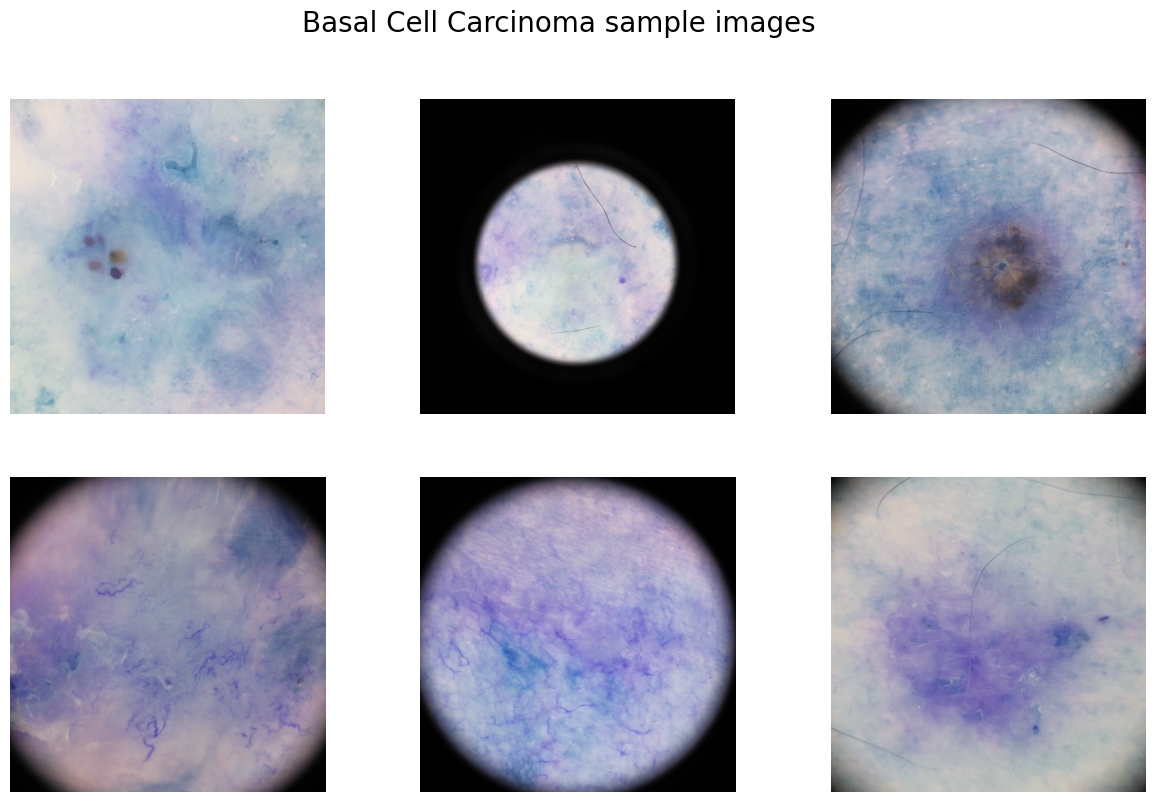

In [8]:
sample_parasite = random.sample(Bimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread("/content/drive/My Drive/ISIC/Basal_cell_carcinoma/train/" +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Basal Cell Carcinoma sample images',fontsize=20)
plt.show()

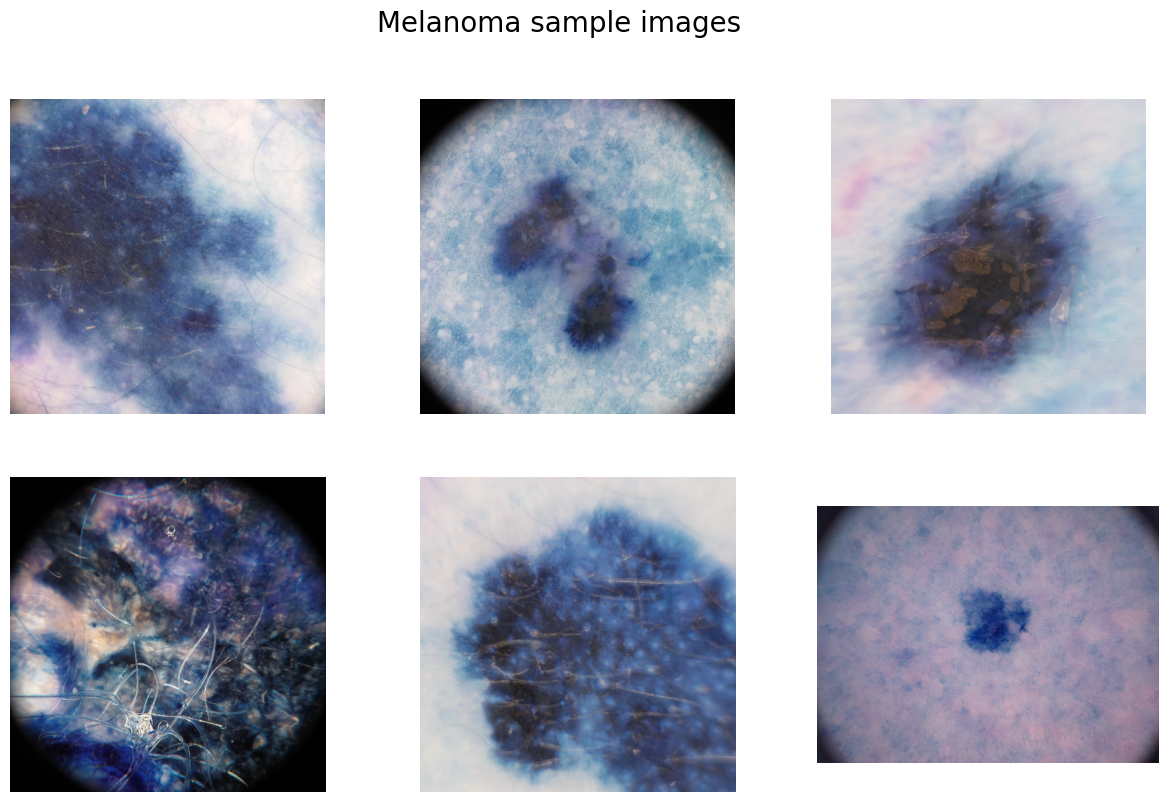

In [9]:
sample_parasite = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Melanoma sample images',fontsize=20)
plt.show()

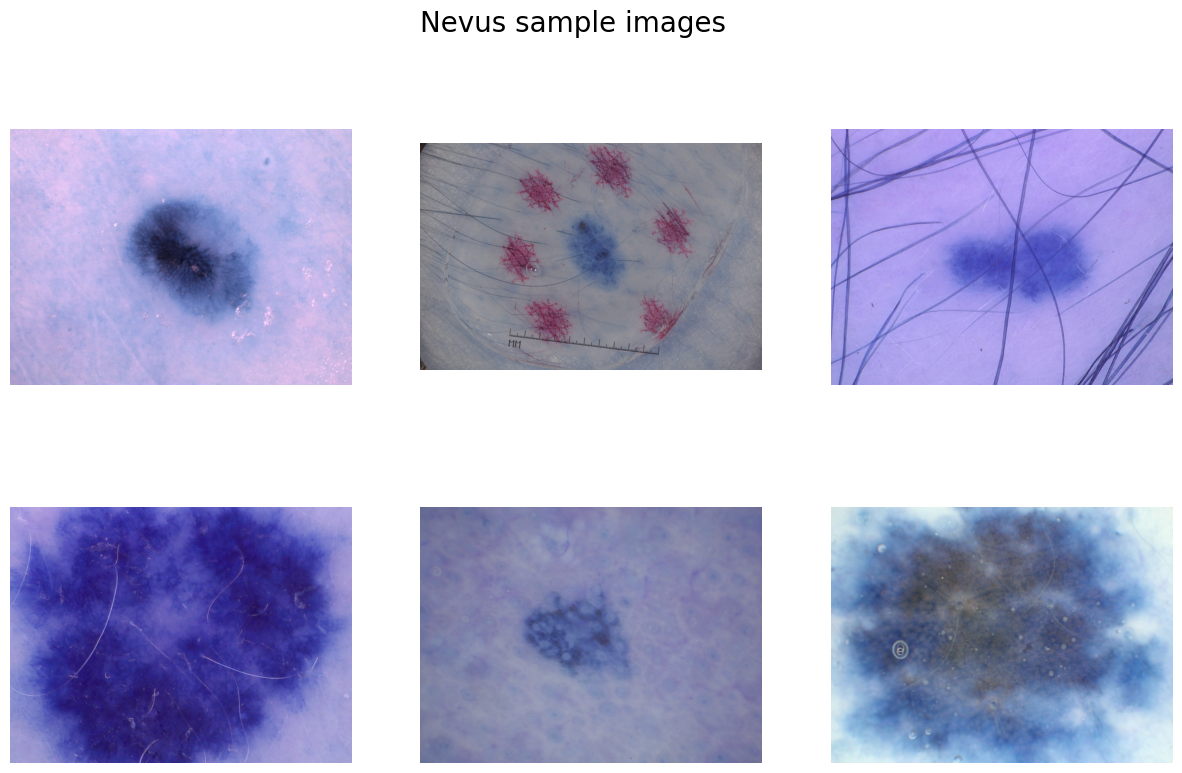

In [10]:
sample_parasite = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(N_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Nevus sample images',fontsize=20)
plt.show()

In [11]:
data=[]
labels=[]
Basal=os.listdir("/content/drive/My Drive/ISIC/Basal_cell_carcinoma/train/")
for a in Basal:
    try:
        image=cv2.imread("/content/drive/My Drive/ISIC/Basal_cell_carcinoma/train/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("/content/drive/My Drive/ISIC/Melanoma/train/")
for b in Melanoma:
    try:
        image=cv2.imread("/content/drive/My Drive/ISIC/Melanoma/train/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("/content/drive/My Drive/ISIC/Nevus/train/")
for c in Nevus:
    try:
        image=cv2.imread("/content/drive/My Drive/ISIC/Nevus/train/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [12]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/My Drive/ISIC/feats_train",feats)
np.save("/content/drive/My Drive/ISIC/labels_train",labels)

In [13]:
feats=np.load("/content/drive/My Drive/ISIC/feats_train.npy")
labels=np.load("/content/drive/My Drive/ISIC/labels_train.npy")

In [14]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [15]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

12445


In [16]:
print(num_classes)

3


In [3]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

NameError: name 'feats' is not defined

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [2]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

NameError: name 'y_train' is not defined